In [1]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os
import scipy.ndimage

In [2]:
# Function to generate an adversarial patch
def generate_patch(patch_size):
    """
    Generate an initial random patch.
    """
    return tf.Variable(tf.random.uniform(patch_size, 0, 1), trainable=True)

In [3]:
def apply_patch(images, patch, patch_size, position=(50, 50), blend_alpha=0.05):
    """
    Apply the patch to a batch of images with mask-based blending to ensure untouched regions remain unchanged.
    """
    # Prepare position and mask
    x, y = position
    batch_size = tf.shape(images)[0]
    mask = tf.zeros_like(images)

    # Create the indices and updates for the patch
    indices, updates = [], []
    for i in range(batch_size):
        for dx in range(patch_size[0]):
            for dy in range(patch_size[1]):
                indices.append([i, x + dx, y + dy])
                updates.append(patch[dx, dy, :])
    indices = tf.constant(indices, dtype=tf.int32)
    updates = tf.convert_to_tensor(updates, dtype=tf.float32)
    mask = tf.tensor_scatter_nd_update(mask, indices, updates)

    # Create a binary mask for the patch region
    binary_mask = tf.where(mask > 0, 1.0, 0.0)

    # Apply blending only in the patch region
    patched_images = images * (1 - binary_mask * blend_alpha) + mask * blend_alpha

    # Clip pixel values to ensure valid image
    patched_images = tf.clip_by_value(patched_images, 0, 1)

    # Debugging
    print(f"Debug - Patched Image Shape: {patched_images.shape}, Min: {tf.reduce_min(patched_images).numpy()}, Max: {tf.reduce_max(patched_images).numpy()}")
    return patched_images


In [4]:
# Add Gaussian smoothing
def smooth_patch(patch, sigma=3):
    return scipy.ndimage.gaussian_filter(patch, sigma=sigma)


In [5]:
def debug_patched_region(patched_image, position, patch_size):
    x, y = position
    patched_region = patched_image[0, x:x + patch_size[0], y:y + patch_size[1], :]
    print("Debug - Patched Region Pixel Values (Min/Max):", tf.reduce_min(patched_region).numpy(), tf.reduce_max(patched_region).numpy())
    plt.imshow(patched_region)
    plt.title("Patched Region Debugging")
    plt.show()


In [6]:
def craft_patch_attack(model_path, image_shape, num_classes, patch_size=(10, 10, 3), learning_rate=0.01, epochs=20):
    """
    Generate an adversarial patch for a trained model.
    """
    # Load the trained model
    model = load_model(model_path)

    # Initialize the patch
    patch = generate_patch(patch_size)
    print("Patch trainable:", patch.trainable)
    #print("Patch values:", patch.numpy())
    print("Debug - Initial Patch Values (Min/Max):")
    print("Min:", tf.reduce_min(patch).numpy(), "Max:", tf.reduce_max(patch).numpy())

    # Define a dummy batch for optimization
    dummy_images = tf.random.uniform((1, image_shape[0], image_shape[1], image_shape[2]))

    # Target label: Adjust for targeted attacks
    target_label = tf.one_hot([0], num_classes)  # Target class 0

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            tape.watch(patch)

            # Apply the patch to the dummy images
            patched_images = apply_patch(dummy_images, patch, patch_size)
            print("Debug crat patch attack patched images")
            debug_patched_region(patched_images, position=(50, 50), patch_size=patch_size)

            # Debugging
            print("Patched Images Shape:", patched_images.shape)

            # Get predictions and calculate loss
            predictions = model(patched_images)
            loss = -tf.reduce_mean(tf.keras.losses.categorical_crossentropy(target_label, predictions))

            # Debugging
            print("Predictions Shape:", predictions.shape)
            print("Loss Value:", loss.numpy())

        # Compute gradients
        gradients = tape.gradient(loss, patch)

        # Debugging
        if gradients is None:
            print("Gradients are None. Check the patch's involvement in the loss computation.")
            break
        else:
            print("Gradients Shape:", gradients.shape)

        # Update patch
        patch.assign_sub(learning_rate * gradients)
        #print("Patch before clipping:", patch.numpy())

        patch.assign(tf.clip_by_value(patch, 0, 1))  # Ensure patch is valid
        #print("Patch after clipping:", patch.numpy())
        patch.assign(tf.convert_to_tensor(smooth_patch(patch.numpy()), dtype=tf.float32))

        print("Epoch {}/{} Loss: {}".format(epoch + 1, epochs, loss.numpy()))
        
    plt.imshow(patch.numpy())
    plt.title("Adversarial Patch")
    plt.show()
    
    # Visualize patched images
    plt.imshow(patched_images[0].numpy())
    plt.title("Patched Image During Debugging")
    plt.show()

    return patch

In [7]:
# Evaluate Patch Attack
def evaluate_patch(model_path, patch_path, test_dataset, patch_size):
    """
    Evaluate the adversarial patch on a model with the test dataset.
    """
    # Load model and patch
    model = load_model(model_path)
    patch = np.load(patch_path)

    success_count = 0
    total_samples = 0

    for images, labels in test_dataset:
        patched_images = apply_patch(images, patch, patch_size)
        print("Debug evaluate patch attack patched images")
        debug_patched_region(patched_images, position=(50, 50), patch_size=patch_size)
        predictions = model.predict(patched_images)
        success_count += np.sum(np.argmax(predictions, axis=1) != labels.numpy())
        total_samples += labels.shape[0]

    success_rate = success_count / total_samples * 100
    print(f"Attack Success Rate: {success_rate:.2f}%")

In [8]:
def scale_for_visualization(images):
    """
    Scale image pixel values from [0, 1] to [0, 255] for visualization purposes.
    """
    return (images * 255).numpy().astype("uint8")


In [9]:
def visualize_patch(patch_path, test_dataset, patch_size):
    patch = np.load(patch_path)
    for images, labels in test_dataset.take(1):
        patched_images = apply_patch(images, patch, patch_size, blend_alpha=0.5)

        # Debug the range
        print("Debug - Pixel Range for Patched Images Before Visualization")
        print("Min:", tf.reduce_min(patched_images).numpy(), "Max:", tf.reduce_max(patched_images).numpy())

        # Scale for visualization
        images_vis = scale_for_visualization(images)
        patched_images_vis = scale_for_visualization(patched_images)

        plt.figure(figsize=(15, 10))
        for i in range(5):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images_vis[i])
            plt.title("Original")
            plt.axis("off")

            plt.subplot(2, 5, i + 6)
            plt.imshow(patched_images_vis[i])
            plt.title("Patched")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

Found 8481 files belonging to 5 classes.
Crafting Adversarial Patch...
Patch trainable: True
Debug - Initial Patch Values (Min/Max):
Min: 0.004234791 Max: 0.9962621
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.015675187 0.9824134


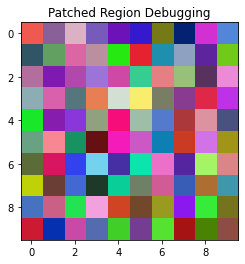

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.610306
Gradients Shape: (10, 10, 3)
Epoch 1/20 Loss: -102.61030578613281
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032262877 0.97379136


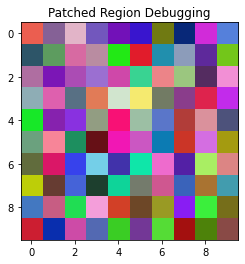

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 2/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032669667 0.9735986


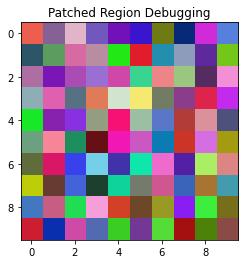

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61033
Gradients Shape: (10, 10, 3)
Epoch 3/20 Loss: -102.6103286743164
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032846257 0.97354037


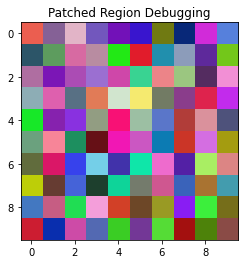

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61033
Gradients Shape: (10, 10, 3)
Epoch 4/20 Loss: -102.6103286743164
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.03294522 0.97351325


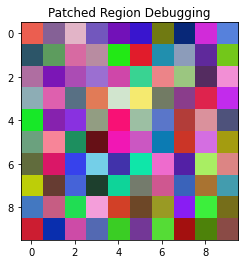

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61033
Gradients Shape: (10, 10, 3)
Epoch 5/20 Loss: -102.6103286743164
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032946445 0.97349775


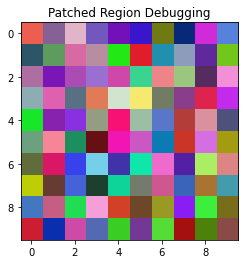

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61033
Gradients Shape: (10, 10, 3)
Epoch 6/20 Loss: -102.6103286743164
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032899104 0.97348815


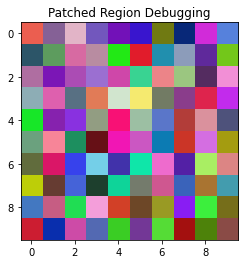

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 7/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032867998 0.97348213


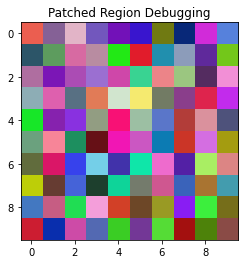

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 8/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032847755 0.97347826


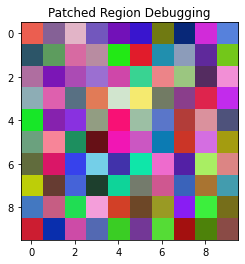

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 9/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032834657 0.97347575


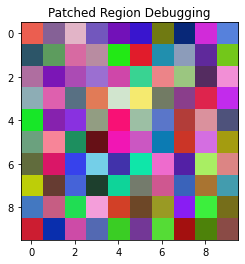

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 10/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.03282621 0.9734742


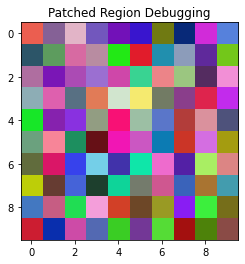

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 11/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032820776 0.9734732


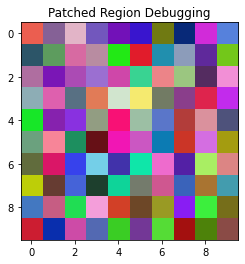

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 12/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.03281728 0.97347254


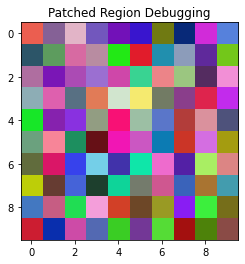

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 13/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032815035 0.9734721


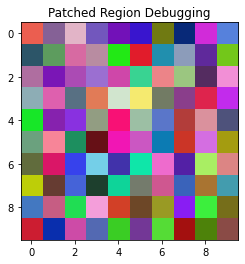

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 14/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032813594 0.9734718


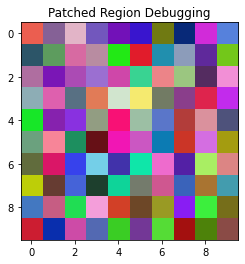

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 15/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.03281267 0.97347164


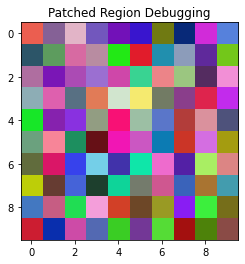

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 16/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032812078 0.9734715


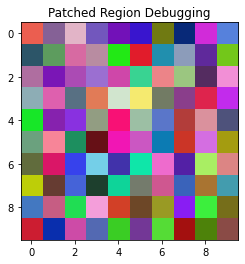

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 17/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032811694 0.97347146


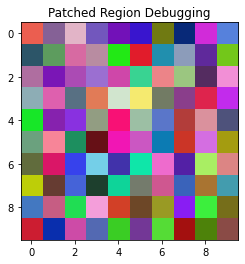

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 18/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.03281145 0.9734714


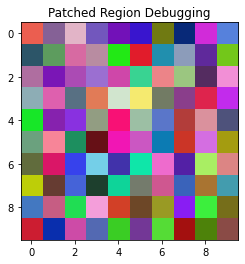

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 19/20 Loss: -102.61032104492188
Debug - Patched Image Shape: (1, 180, 180, 3), Min: 4.887580871582031e-06, Max: 0.9999964237213135
Debug crat patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.032811295 0.9734714


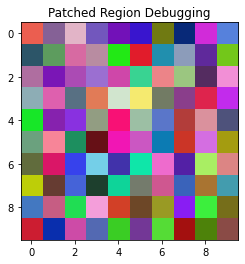

Patched Images Shape: (1, 180, 180, 3)
Predictions Shape: (1, 5)
Loss Value: -102.61032
Gradients Shape: (10, 10, 3)
Epoch 20/20 Loss: -102.61032104492188


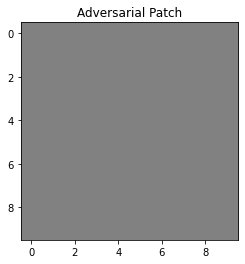

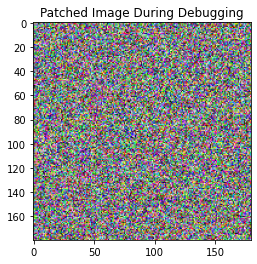

Adversarial patch saved as 'adversarial_patch.npy'.
Evaluating Adversarial Patch...
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.23673747 0.92641294


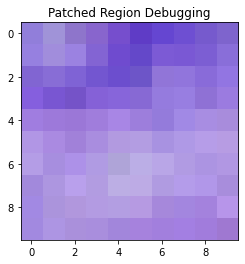

2/2 [==============================] - 0s 93ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.08878596 0.9754652


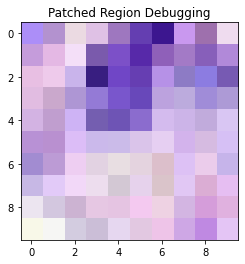

2/2 [==============================] - 0s 112ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.39508367 0.97546524


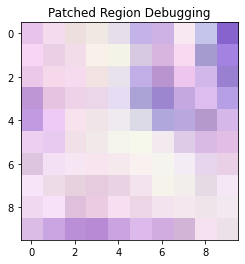

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.16346905 0.975465


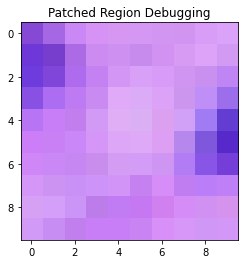

2/2 [==============================] - 0s 108ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.5465121 0.9754652


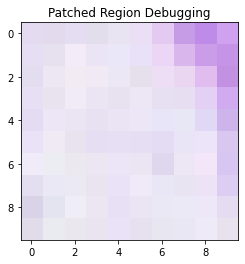

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.7784733 0.82309234


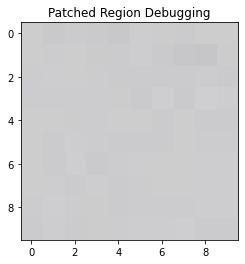

2/2 [==============================] - 0s 98ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.2834555 0.927406


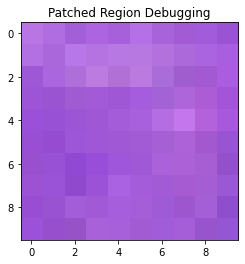

2/2 [==============================] - 0s 111ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.2310752 0.94032127


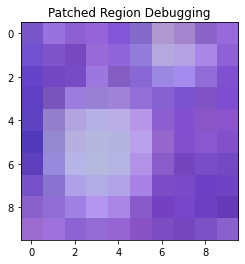

2/2 [==============================] - 0s 115ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.45104033 0.91449094


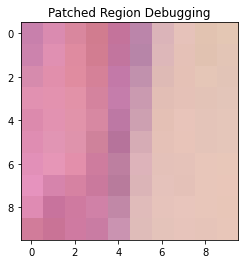

2/2 [==============================] - 0s 105ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.22084261 0.9754652


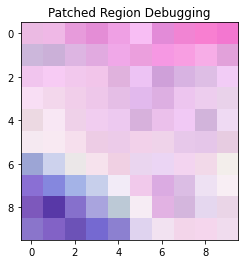

2/2 [==============================] - 0s 106ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.31491464 0.9446677


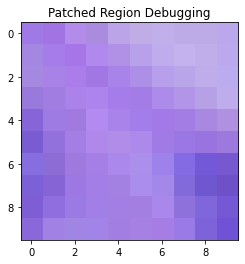

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.28634036 0.9754649


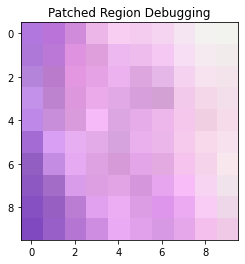

2/2 [==============================] - 0s 106ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.2345888 0.9283084


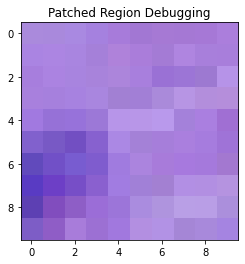

2/2 [==============================] - 0s 113ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.38447925 0.97546494


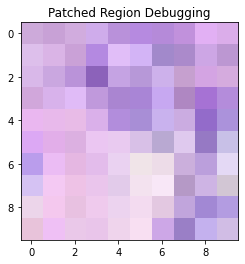

2/2 [==============================] - 0s 106ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.1591742 0.97546506


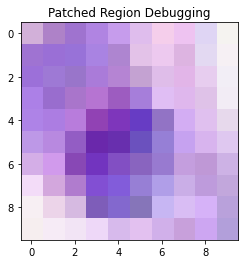

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.6545762 0.9754652


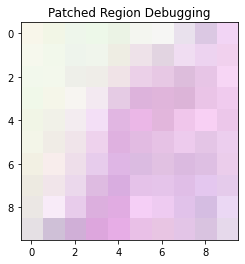

2/2 [==============================] - 0s 105ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.25675568 0.975465


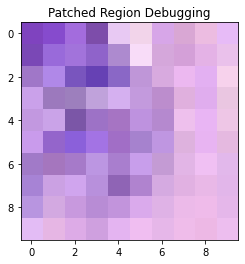

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.37297428 0.9754652


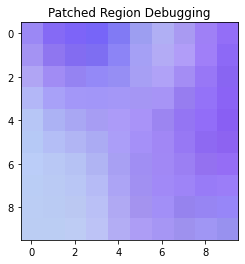

2/2 [==============================] - 0s 122ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.4612363 0.9754652


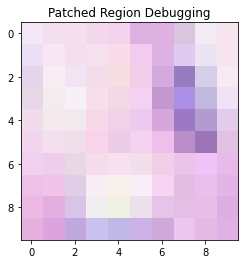

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.15213175 0.9754648


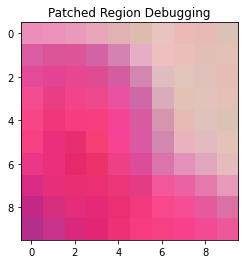

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.77123797 0.916416


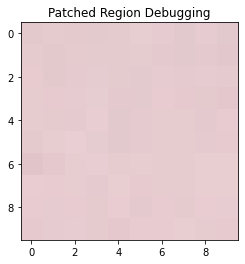

2/2 [==============================] - 0s 106ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.17703028 0.9703855


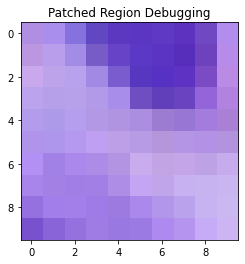

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.06296899 0.9754649


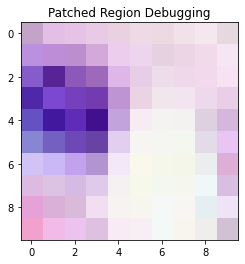

2/2 [==============================] - 0s 106ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3789393 0.97537


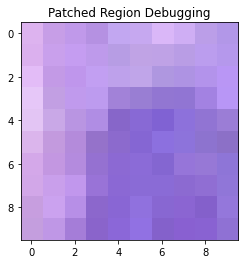

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.026329968 0.9754652


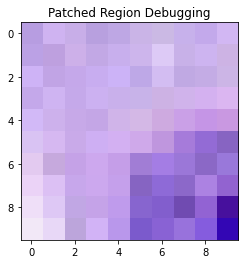

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.188021 0.9378458


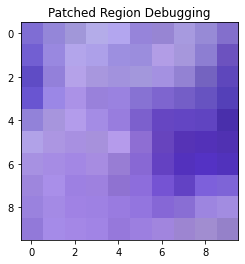

2/2 [==============================] - 0s 98ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.25455397 0.9559684


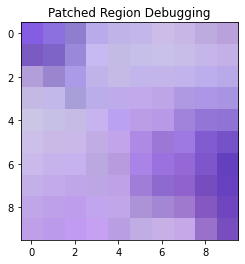

2/2 [==============================] - 0s 100ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.1780235 0.9754652


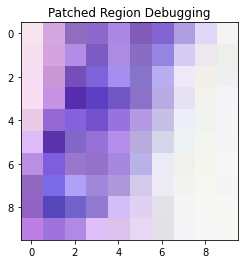

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.025465194 0.89693546


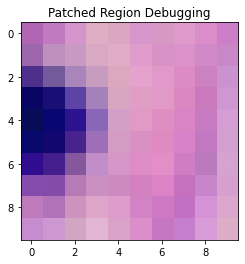

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.12258838 0.8265697


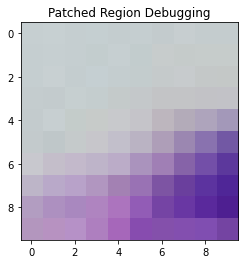

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.23992889 0.9754652


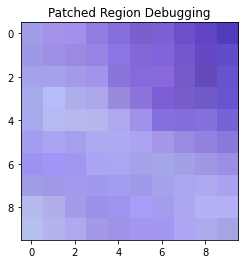

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.26246667 0.9754651


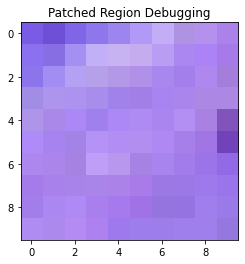

2/2 [==============================] - 0s 107ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.35781983 0.9754652


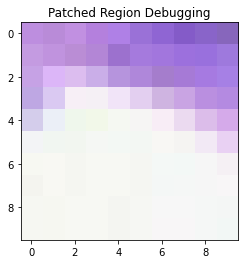

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.24593489 0.92075413


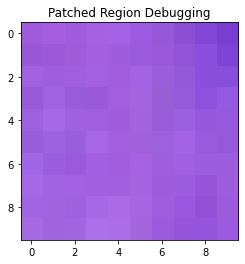

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.27817798 0.97198766


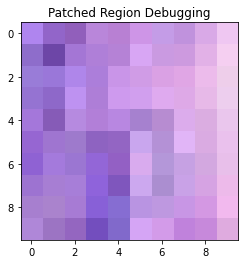

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.37774748 0.92483157


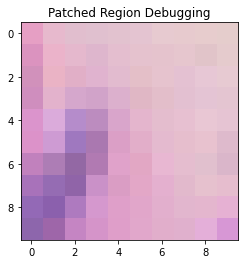

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.23392724 0.9747654


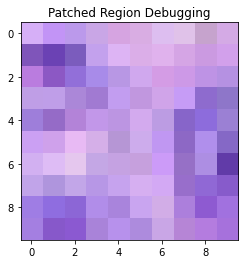

2/2 [==============================] - 0s 103ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3862205 0.974012


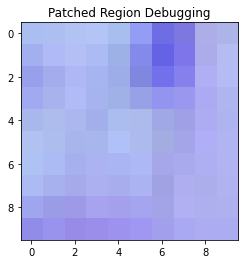

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.286618 0.9754652


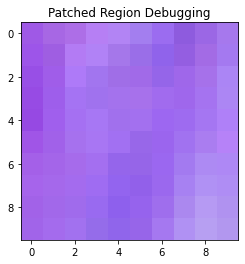

2/2 [==============================] - 0s 100ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.4178674 0.9754652


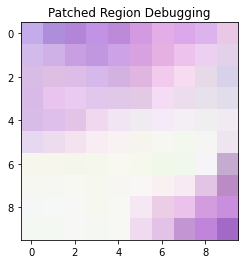

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3725027 0.9035253


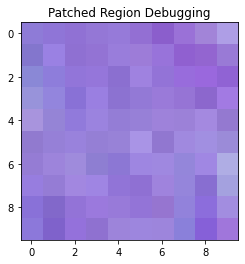

2/2 [==============================] - 0s 98ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.6994024 0.85226285


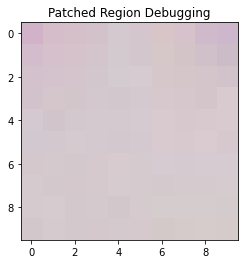

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.48336834 0.90083116


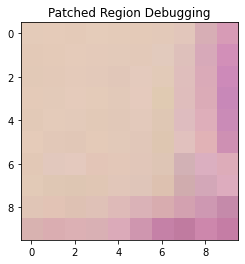

2/2 [==============================] - 0s 105ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.11900395 0.9295587


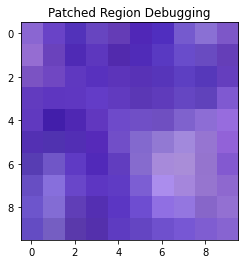

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.029927395 0.9754652


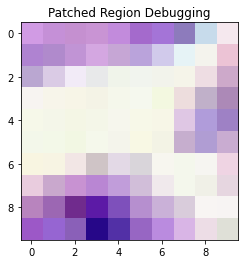

2/2 [==============================] - 0s 99ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.40546492 0.97447157


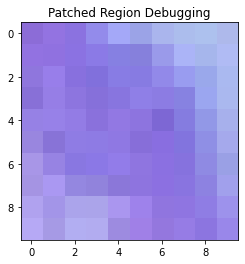

2/2 [==============================] - 0s 99ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.45079157 0.975465


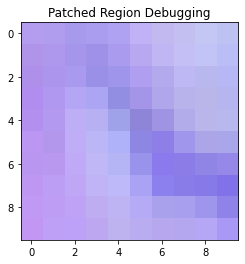

2/2 [==============================] - 0s 100ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.4420286 0.9616763


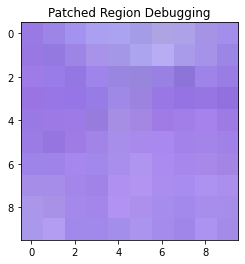

2/2 [==============================] - 0s 108ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.2830328 0.8428375


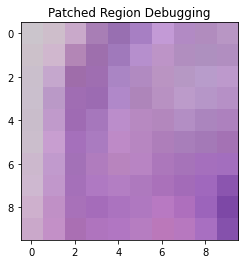

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.44085705 0.85624915


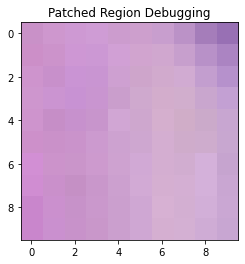

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.18681587 0.9420557


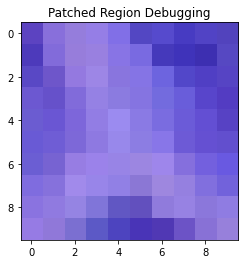

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.34455478 0.9754648


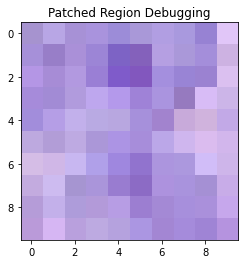

2/2 [==============================] - 0s 100ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.20151065 0.9699514


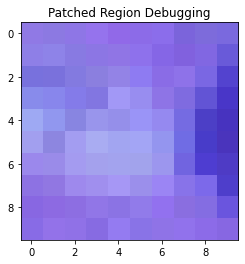

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.025464851 0.9602985


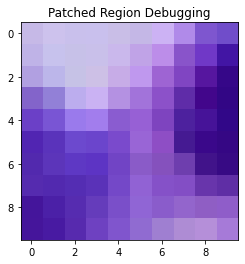

2/2 [==============================] - 0s 95ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.37513047 0.81692034


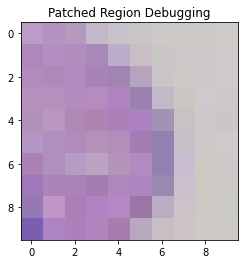

2/2 [==============================] - 0s 94ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.18174542 0.9696779


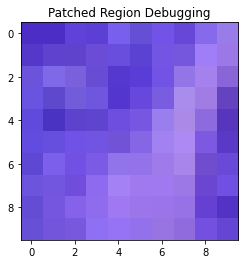

2/2 [==============================] - 0s 95ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.4830339 0.8905659


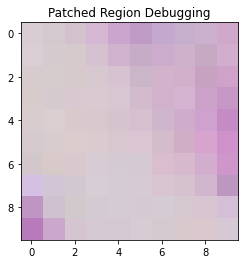

2/2 [==============================] - 0s 98ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.24326564 0.975465


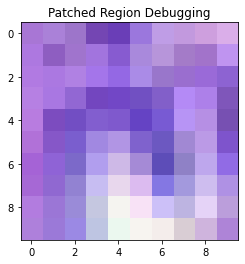

2/2 [==============================] - 0s 105ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.37847197 0.9568335


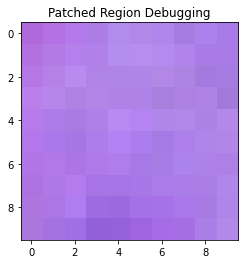

2/2 [==============================] - 0s 100ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.4815894 0.9449158


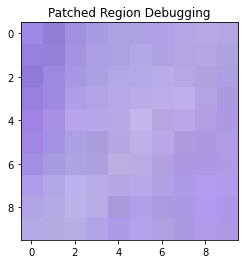

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.7845958 0.87624276


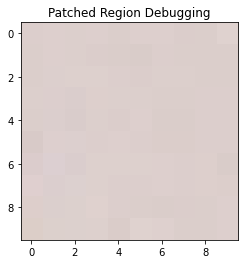

2/2 [==============================] - 0s 100ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.34971932 0.9754652


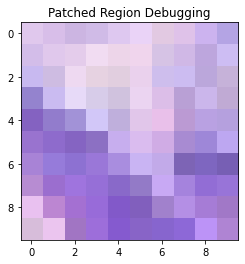

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.062719874 0.9748567


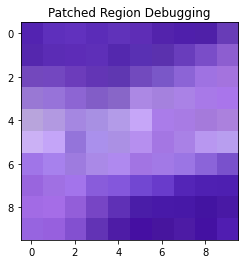

2/2 [==============================] - 0s 109ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.102831505 0.94721377


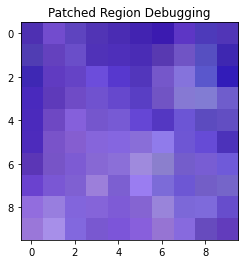

2/2 [==============================] - 0s 103ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.399132 0.95218056


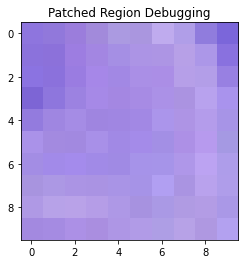

2/2 [==============================] - 0s 99ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.46724623 0.93075895


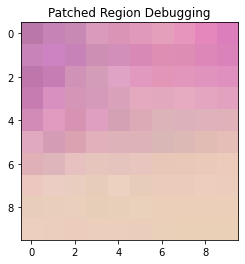

2/2 [==============================] - 0s 105ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3010881 0.97075003


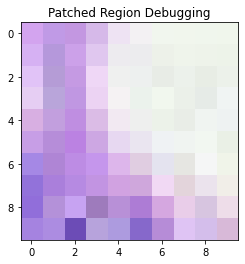

2/2 [==============================] - 0s 114ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.5126099 0.8860325


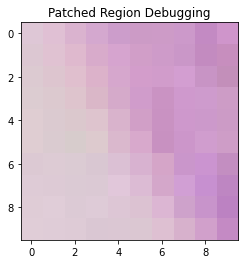

2/2 [==============================] - 0s 105ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.027646722 0.89350444


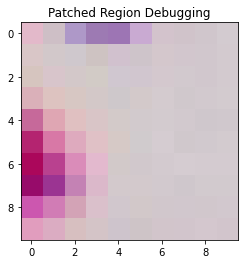

2/2 [==============================] - 0s 107ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.31040287 0.9750925


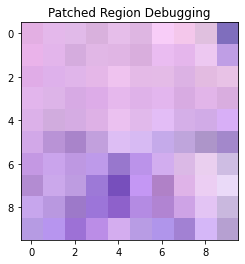

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.66004 0.8433219


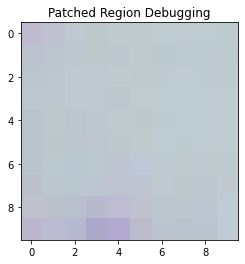

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.26101935 0.9754652


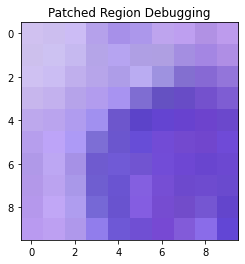

2/2 [==============================] - 0s 108ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3141644 0.95944494


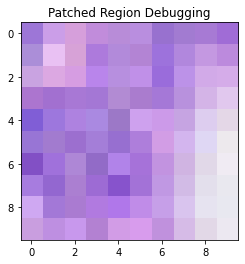

2/2 [==============================] - 0s 103ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.42997438 0.9754652


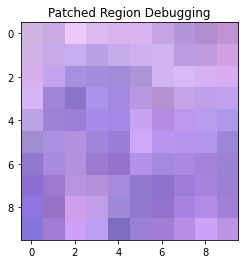

2/2 [==============================] - 0s 103ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.109098375 0.95373327


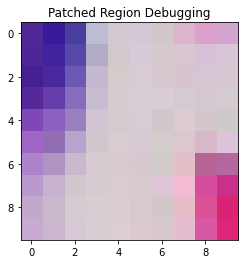

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.29723158 0.9279649


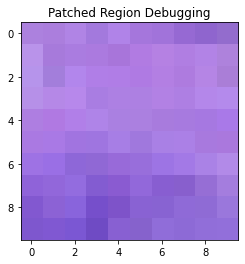

2/2 [==============================] - 0s 107ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.5400913 0.96986413


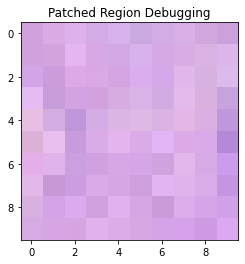

2/2 [==============================] - 0s 103ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.19466317 0.9754652


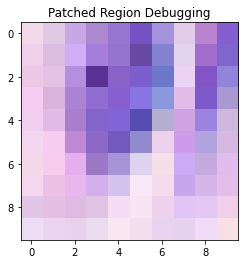

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.2927198 0.97546506


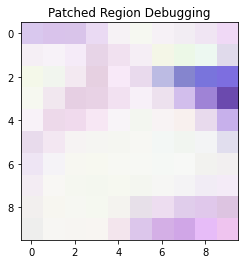

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.344926 0.9754651


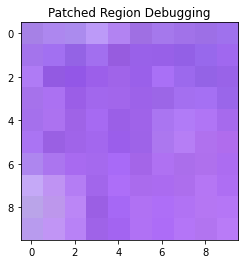

2/2 [==============================] - 0s 105ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.12569338 0.97546506


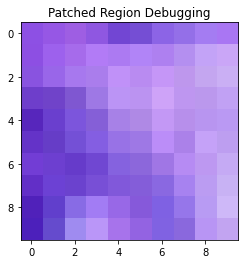

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.7566543 0.97546494


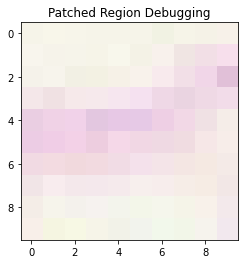

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.10481812 0.9269092


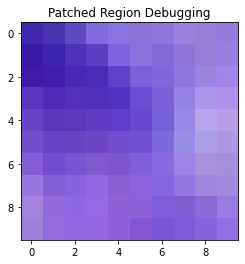

2/2 [==============================] - 0s 95ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.5307032 0.9754649


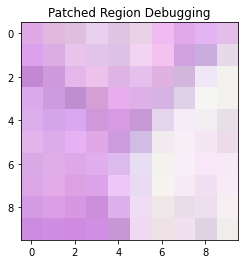

2/2 [==============================] - 0s 96ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.19880809 0.9432192


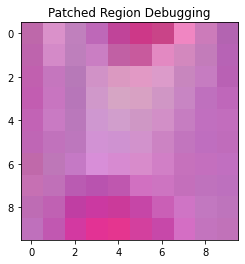

2/2 [==============================] - 0s 100ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.47162968 0.97326297


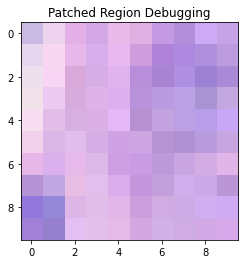

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.34047648 0.97285736


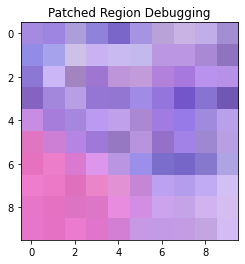

2/2 [==============================] - 0s 99ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.74442255 0.81899434


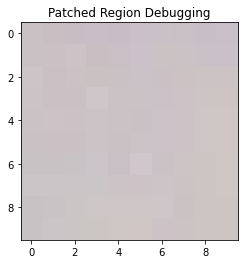

2/2 [==============================] - 0s 112ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.22221649 0.89766455


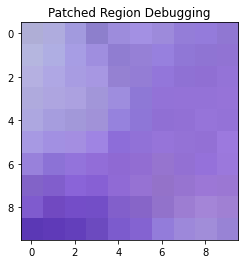

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3361701 0.9195701


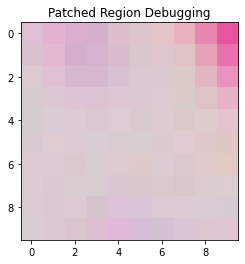

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.4134342 0.8828247


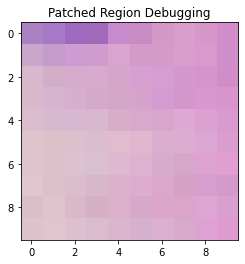

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.22440639 0.94466776


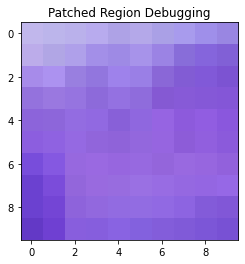

2/2 [==============================] - 0s 105ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3242752 0.9754652


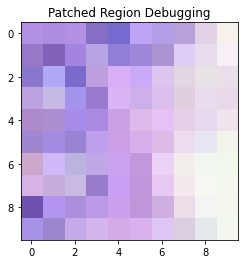

2/2 [==============================] - 0s 98ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.31781214 0.96391606


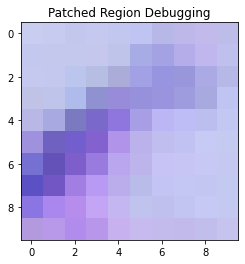

2/2 [==============================] - 0s 99ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.030784562 0.9749268


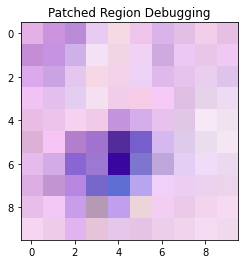

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.43526915 0.96205306


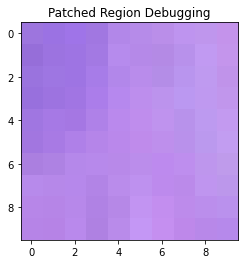

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.27529198 0.9691768


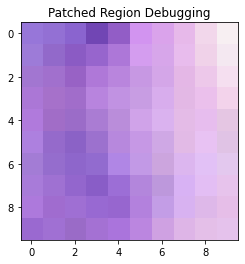

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3843538 0.927882


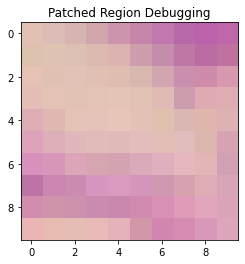

2/2 [==============================] - 0s 99ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3141759 0.9754652


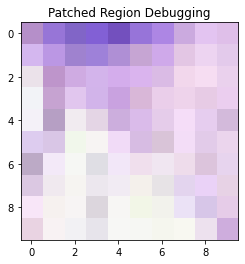

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.02589948 0.9754652


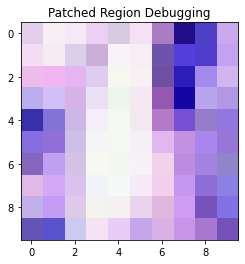

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3998641 0.9754651


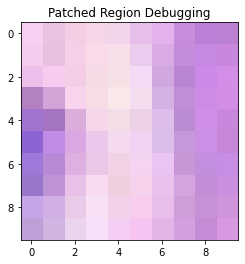

2/2 [==============================] - 0s 99ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.031798452 0.93994874


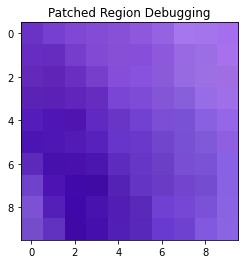

2/2 [==============================] - 0s 100ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.88361514 0.97546506


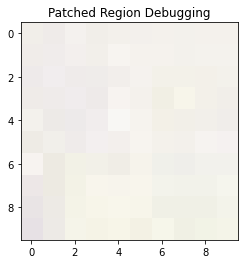

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.4119853 0.975465


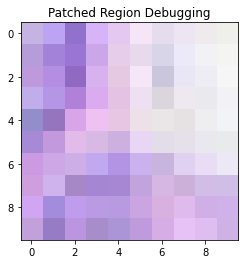

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.25231415 0.9754652


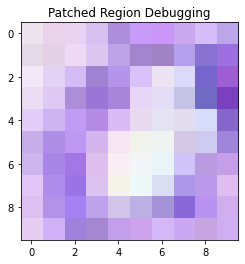

2/2 [==============================] - 0s 103ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.17592914 0.9579551


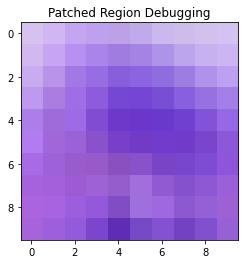

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.1038869 0.8641848


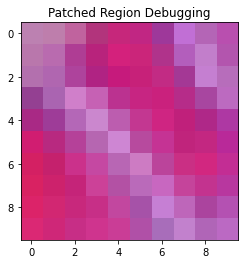

2/2 [==============================] - 0s 110ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.02546503 0.9754651


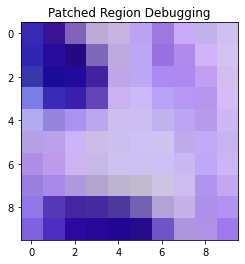

2/2 [==============================] - 0s 122ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.28240004 0.9754648


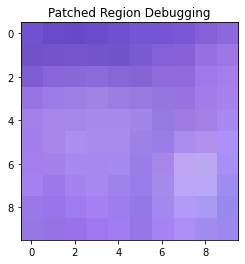

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.5325493 0.92815155


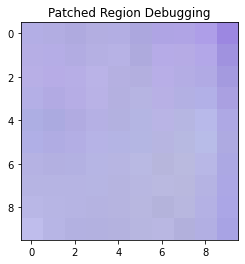

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.7576479 0.88977873


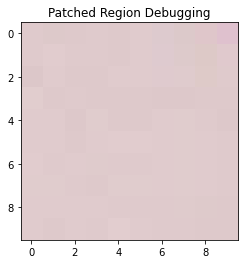

2/2 [==============================] - 0s 112ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.35708338 0.97546524


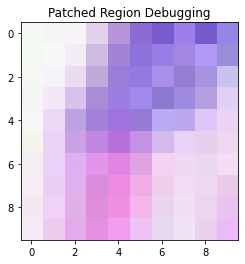

2/2 [==============================] - 0s 105ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3446152 0.847399


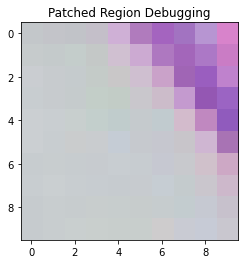

2/2 [==============================] - 0s 105ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.11984438 0.9470268


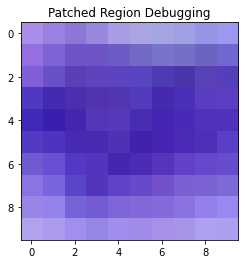

2/2 [==============================] - 0s 108ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.58800167 0.9754652


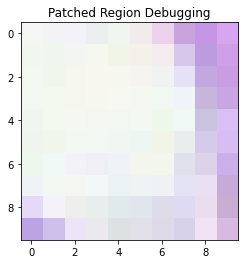

2/2 [==============================] - 0s 103ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3015271 0.9300142


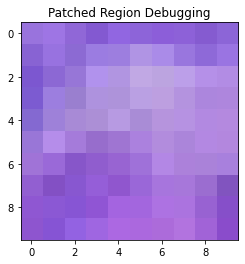

2/2 [==============================] - 0s 103ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.025464913 0.9676414


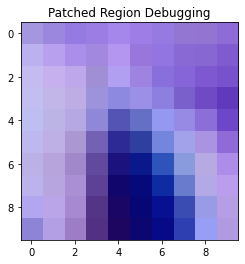

2/2 [==============================] - 0s 104ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.43582764 0.81837344


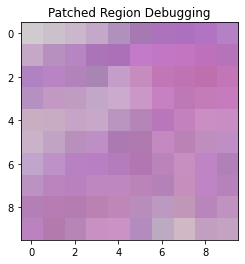

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.22788304 0.9451013


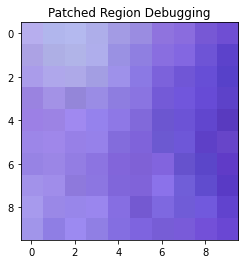

2/2 [==============================] - 0s 106ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.18636931 0.91485953


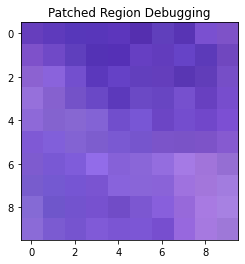

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.2403884 0.96656126


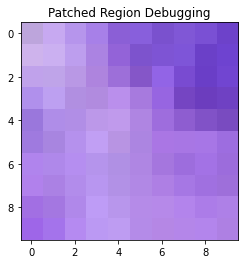

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.44823334 0.97546494


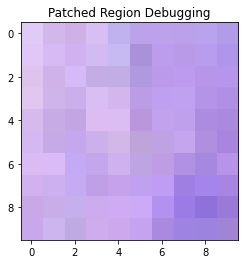

2/2 [==============================] - 0s 103ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.40071243 0.8737588


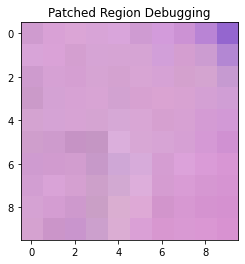

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.30877212 0.9414475


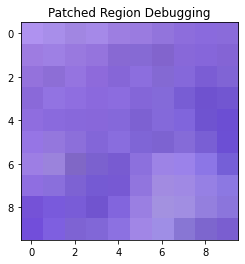

2/2 [==============================] - 0s 103ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.31836694 0.9754652


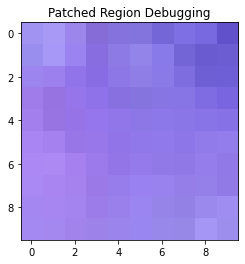

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.6812751 0.97312623


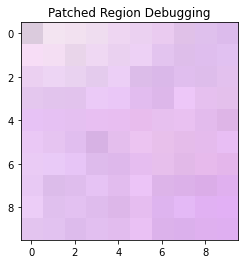

2/2 [==============================] - 0s 109ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.3272297 0.9754652


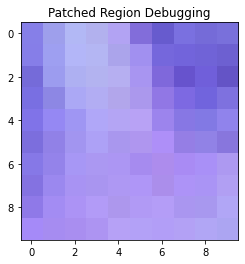

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.03463426 0.9754652


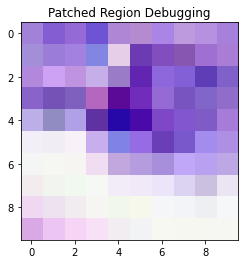

2/2 [==============================] - 0s 101ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.41549948 0.9733497


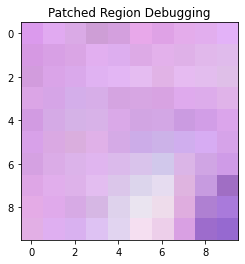

2/2 [==============================] - 0s 102ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.12940598 0.96615124


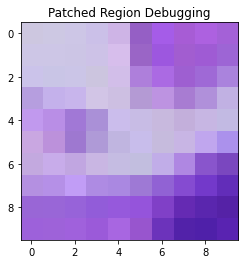

2/2 [==============================] - 0s 103ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.5371323 0.9754652


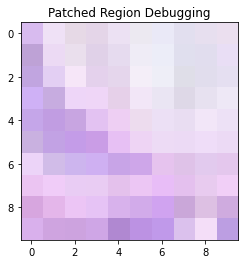

2/2 [==============================] - 0s 106ms/step
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.28946537 0.9706551


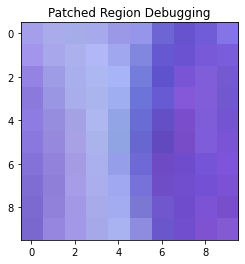

2/2 [==============================] - 0s 112ms/step
Debug - Patched Image Shape: (33, 180, 180, 3), Min: 0.0, Max: 1.0
Debug evaluate patch attack patched images
Debug - Patched Region Pixel Values (Min/Max): 0.50585 0.95549214


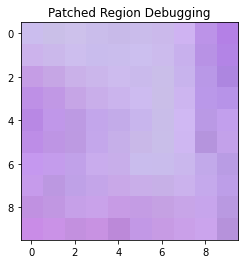

2/2 [==============================] - 0s 8ms/step
Attack Success Rate: 79.88%
Visualizing Adversarial Patch...
Debug - Patched Image Shape: (64, 180, 180, 3), Min: 0.0, Max: 1.0
Debug - Pixel Range for Patched Images Before Visualization
Min: 0.0 Max: 1.0


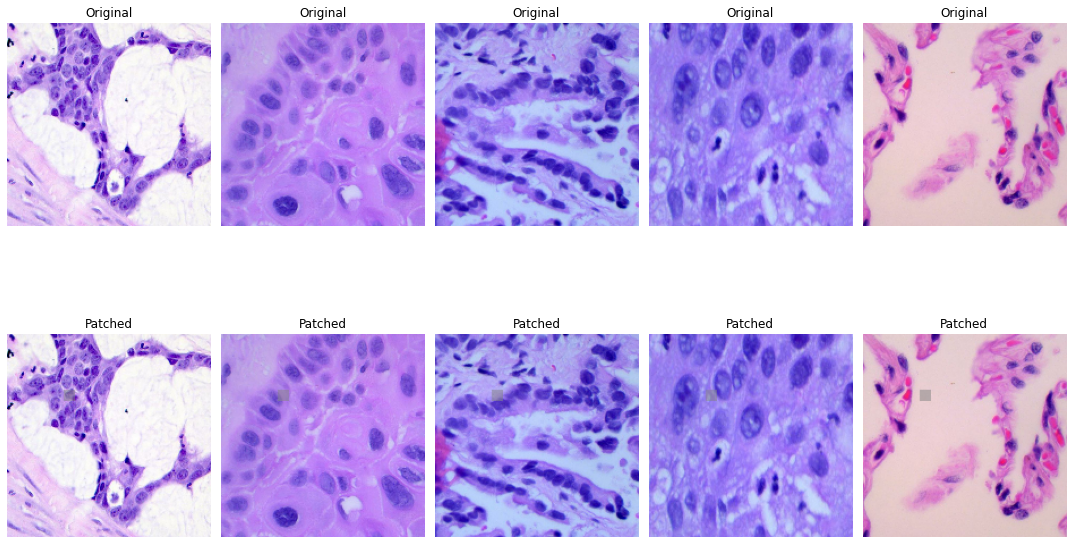

In [10]:
# Dataset Preparation
dirpath = "/home/mandal.n/VML/Project/Data/image_sets"
IMG_SIZE = 180
BATCH_SIZE = 64
CHANNELS = 3
N_CLASSES = 5

# Load the dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dirpath,
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))

# Patch Parameters
image_shape = (IMG_SIZE, IMG_SIZE, CHANNELS)
patch_size = (10, 10, 3)
model_path = "/home/mandal.n/VML/Project/model/cnn_model.h5"

# Step 1: Craft the Patch
print("Crafting Adversarial Patch...")
adversarial_patch = craft_patch_attack(model_path, image_shape, N_CLASSES, patch_size)
np.save("adversarial_patch.npy", adversarial_patch.numpy())
print("Adversarial patch saved as 'adversarial_patch.npy'.")

# Step 2: Evaluate the Patch
print("Evaluating Adversarial Patch...")
evaluate_patch(model_path, "adversarial_patch.npy", test_dataset, patch_size)

# Step 3: Visualize the Patch
print("Visualizing Adversarial Patch...")
visualize_patch("adversarial_patch.npy", test_dataset, patch_size)